# Second exercise (Chapter 6 & 8)

In this exercise we consider Chapters 6 & 8 of the book "Deep Learning". The exercise focuses on implementing a small feedforward neural network and training it on the MNIST dataset.

We provide code for structure and utility, you have to **fill in the TODO-gaps**.
It might initially look like a lot of unnecessary code, but it keeps the network extensible. In the following exercises you can reuse what you've done here. Most common neural network libraries (*pytorch*, *tensorflow/keras*, …) are similarly structured, hence they will be easy to use once you've finished this notebook. As we will be using *pytorch* towards the end of the lecture, our API resembles the API of the pytorch framework.


We will implement two different cost functions and play a bit with the value of the different hyperparameters to see how performances change as a function of those. In particular, we will focus on

* Sigmoid Neurons
* Stochastic Gradient Descent
* Quadratic Cost Function
* Cross Entropy Cost Function
* Learning Rate
* Generalization

Note that we'll implement all of these operations to operate on mini-batches of data.

In [1]:
# Some imports used in the code below

from typing import Iterable, List, Optional, Tuple  # type annotations
import pickle  # data loading
import gzip  # data loading

import numpy as np  # linear algebra
import matplotlib.pyplot as plt  # plotting
import scipy.optimize  # gradient check

The cell below contains the two main classes to structure your network. 

**Parameter** is used to represent trainable variables in the network, e.g., a layer's weights $w$. The weights themself are a *numpy array* as the parameter's `data` attribute. The associated parameter gradient (e.g. $\frac{\partial L}{\partial w}$) can be stored in the `grad` attribute.



**Module** is the base class for all parts of the network (activations, layers, …) and even the network itself. They all have to implement the `forward` and `backward` methods. For backpropagation activation will flow *forward* and gradient will flow *backward* through the *network graph and it's modules*. 

Additional module provides utility to check the correctness of implementation by approximating *backward* with [finite difference approximations](https://en.wikipedia.org/wiki/Finite_difference#Relation_with_derivatives)  of *forward*.

*Note:* All modules operate on batches of samples. E.g. the input shape of `Linear.forward` is `(batch_size, feature_shape, 1)` (we will use the last dimension in future exercises).

In [2]:
class Parameter:
    """A trainable parameter.

    This class not only stores the value of the parameter (self.data) but also tensors/
    properties associated with it, such as the gradient (self.grad) of the current backward
    pass.
    """

    def __init__(self, data: np.ndarray, grad: Optional[np.ndarray] = None, name=None):
        self.data = data  # type: np.ndarray
        self.grad = grad  # type: Optional[np.ndarray]
        self.name = name  # type: Optional[str]
        self.state_dict = dict()  # dict to store additional, optional information
        
        
class Module:
    """The base class all network modules must inherit from."""

    def __init__(self):
        # Cache of the input of the forward pass.
        # We need it during the backward pass in most layers,
        #  e.g., to compute the gradient w.r.t to the weights.
        self.input_cache = None

    def __call__(self, *args) -> np.ndarray:
        """Alias for forward, convenience function."""
        return self.forward(*args)

    def forward(self, *args) -> np.ndarray:
        """Compute the forward pass through the module.

        Args:
           args: The inputs, e.g., the output of the previous layer.
        """
        raise NotImplementedError

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Compute the backward pass through the module.

        This method computes the gradients with respect to the trainable
        parameters and with respect to the first input.
        If the module has trainable parameters, this method needs to update
        the respective parameter.grad property.

        Args:
            grad: The gradient of the following layer.

        Returns:
            The gradient with respect to the first input argument. In general
            it might be useful to return the gradients w.r.t. to all inputs, we
            omit this here to keep things simple.
        """
        raise NotImplementedError

    def parameters(self) -> List[Parameter]:
        """Return the module parameters."""
        return []  # default to empty list

    def check_gradients(self, input_args: Tuple[np.ndarray]):
        """Verify the implementation of the gradients.

        This includes the gradient with respect to the input as well as the
        gradients w.r.t. the parameters if the module contains any.

        As the scipy grad check only works on scalar functions, we compute
        the sum over the output to obtain a scalar.
        """
        assert isinstance(input_args, tuple), (
            "input_args must be a tuple but is {}".format(type(input_args)))
        TOLERANCE = 1e-6
        self.check_gradients_wrt_input(input_args, TOLERANCE)
        self.check_gradients_wrt_params(input_args, TOLERANCE)

    def _zero_grad(self):
        """(Re-) intialize the param's grads to 0. Helper for grad checking."""
        for p in self.parameters():
            p.grad = np.zeros_like(p.data)

    def check_gradients_wrt_input(self, input_args: Tuple[np.ndarray],
                                  tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. input."""

        def output_given_input(x: np.ndarray):
            """Wrap self.forward for scipy.optimize.check_grad."""
            # we only compute the gradient w.r.t. to the first input arg.
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            return np.sum(self.forward(*args))

        def grad_given_input(x: np.ndarray):
            """Wrap self.backward for scipy.optimize.check_grad."""
            self._zero_grad()
            # run self.forward to store the new input
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            out = self.forward(*args)
            # compute the gradient w.r.t. to the input
            return np.ravel(self.backward(np.ones_like(out)))

        error = scipy.optimize.check_grad(
            output_given_input, grad_given_input, np.ravel(input_args[0]))
        num_outputs = np.prod(self.forward(*input_args).shape)
        if np.squeeze(error) / num_outputs > tolerance:
            raise RuntimeError("Check of gradient w.r.t. to input for {} failed."
                               "Error {:.4E} > {:.4E}."
                               .format(self, np.squeeze(error), tolerance))

    def check_gradients_wrt_params(self, input_args: Tuple[np.ndarray],
                                   tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. params."""
        for param in self.parameters():
            def output_given_params(new_param: np.ndarray):
                """Wrap self.forward, change the parameters to new_param."""
                param.data = new_param.reshape(param.data.shape)
                return np.sum(self.forward(*input_args))

            def grad_given_params(new_param: np.ndarray):
                self._zero_grad()
                param.data = new_param.reshape(param.data.shape)
                out = self.forward(*input_args)
                # compute the gradient w.r.t. to param
                self.backward(np.ones_like(out))
                return np.ravel(param.grad)
            # flatten the param as scipy can only handle 1D params
            param_init = np.ravel(np.copy(param.data))
            error = scipy.optimize.check_grad(output_given_params,
                                              grad_given_params,
                                              param_init)
            num_outputs = np.prod(self.forward(*input_args).shape)
            if np.squeeze(error) / num_outputs > tolerance:
                raise RuntimeError("Check of gradient w.r.t. to param '{}' for"
                                   "{} failed. Error {:.4E} > {:.4E}."
                                   .format(param.name, self, error, tolerance))

# Nonlinearities

## Sigmoid 

Implement your first network module: The sigmoid activation function.

Verify your sigmoid function by plotting.

In [3]:
class Sigmoid(Module):
    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        # START TODO ################ -> DONE
        
        return 1.0/(1.0+np.exp(-z))
        
        #raise NotImplementedError
        # END TODO###################

    # New function for derivative of Sigmoid
    def sigmoid_d(self, h):
        return h*(1-h)    
    
    def forward(self, z: np.ndarray) -> np.ndarray:
        assert len(z.shape) == 3, ("z.shape should be (batch_size, input_size, 1)"
                                   " but is {}.".format(z.shape))
        h = self._sigmoid(z)
        # here it's useful to store the activation 
        #  instead of the input
        self.input_cache = h
        
        return h

    def backward(self, grad: np.ndarray) -> np.ndarray:
        h = self.input_cache
        # START TODO ################ -> DONE
        
        return grad*self.sigmoid_d(h)
        
        #raise NotImplementedError
        # END TODO###################

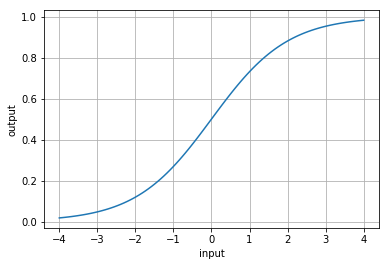

In [4]:
x = np.linspace(-4, +4, 100)
sigmoid = Sigmoid()

y = np.ravel(sigmoid(x.reshape(-1, 1, 1)))
# equal to call of sigmoid.forward(x)
    
plt.plot(x,y)
plt.xlabel('input')
plt.ylabel('output')
plt.grid(True)
plt.show()

## Relu

Implement Relu and plot for verification

In [5]:
class Relu(Module):
    
    def _relu(self, z: np.ndarray) -> np.ndarray:
        return np.maximum(0.0, z)
      
    def relu_d(self,x:np.ndarray):
         return (x > 0).astype(float)
        
    def forward(self, z: np.ndarray) -> np.ndarray:
        self.input_cache = z
        # START TODO ################ -> DONE
        
        h = self._relu(z)

        return h
    
        #raise NotImplementedError
        # END TODO###################

    def backward(self, grad: np.ndarray) -> np.ndarray:
        z = self.input_cache
        # START TODO ################ -> DONE
        
        return grad * self.relu_d(z)
        
        #raise NotImplementedError
        # END TODO###################

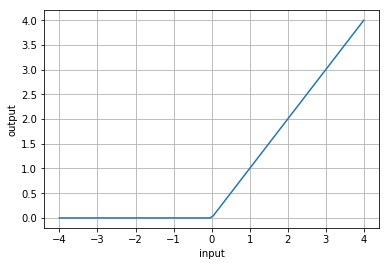

In [6]:
# Plot Relu

# START TODO ################ -> DONE

x = np.linspace(-4, +4, 100)
relu = Relu()

y = np.ravel(relu(x.reshape(-1, 1, 1)))
# equal to call of relu.forward(x)

plt.plot(x,y)
plt.xlabel('input')
plt.ylabel('output')
plt.grid(True)
plt.show()

# END TODO###################

## Softmax

Implement the numerical stable softmax. We will not need the backward pass. 

In [7]:
class Softmax(Module):
    def _softmax(self, z):
        # don't reduce (sum) over batch axis
        reduction_axes = tuple(range(1, len(z.shape))) 
        
        # START TODO ################ -> DONE
        
        reduction_axes = tuple(range(1, len(z.shape)))
        z_max = np.max(z, axis=reduction_axes, keepdims=True)
        
        # Shift input for numerical stability.
        z_safe = z - z_max
        e_z = np.exp(z_safe)
        h = e_z / np.sum(e_z, axis=reduction_axes, keepdims=True)
 
        #raise NotImplementedError
        # END TODO###################
        
        return h
    
    def forward(self, z: np.ndarray) -> np.ndarray:
        h = self._softmax(z)
        return h

    def backward(self, grad) -> np.ndarray:
        error_msg = ("Softmax doesn't need to implement a gradient here, as it's"
                     "only needed in CrossEntropyLoss, where we can simplify"
                     "the gradient for the combined expression.")
        raise NotImplementedError(error_msg)


In [8]:
# Check your softmax
softmax = Softmax()
x = np.array([1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0]).reshape(1, -1, 1)

# Testcase from https://en.wikipedia.org/wiki/Softmax_function#Example
np.testing.assert_allclose(
    np.ravel(softmax(x)), 
    [0.02364054, 0.06426166, 0.1746813, 0.474833, 0.02364054, 0.06426166, 0.1746813],
    rtol=1e-5, err_msg="Softmax is not correct implemented")


# Linear Layer

Implement a linear (in other frameworks also called dense or fully connected) network layer. 
Here you also have to use the Parameter class.

In [9]:
class Linear(Module):

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        
        w_data = 0.01 * np.random.randn(out_features, in_features)
        self.W = Parameter(w_data, "W")
        
        b_data = 0.01 * np.ones((out_features, 1))
        self.b = Parameter(b_data, "b")

    def forward(self, x: np.ndarray) -> np.ndarray:
        assert len(x.shape) == 3, ("x.shape should be (batch_size, input_size, 1)"
                                   " but is {}.".format(x.shape))
        self.input_cache = x
        # START TODO ################ -> DONE
        # Remember: Access weight data through self.W.data
        
        #print("Shape of W.data: ", self.W.data.shape) #(30, 10)
        #print("Shape of b.data: ", self.b.data.shape) #(30, 1)
                
        x_transpose = np.transpose(x, [0, 2, 1])
        #print("Shape of x: ", x.shape) #(2, 10, 1) (NxDx1) 
        #print("Shape of x transpose: ", x_transpose.shape) #(2, 1, 10) (Nx1xD)

        output = (np.matmul(self.W.data,x)) + self.b.data
        #print('Shape of the output',np.shape(output)) #(2, 30, 1)
               
        # Linear layer -> Activation function (z) = z. "output" keeps the same value
        return output        
            
        #raise NotImplementedError
        # END TODO ##################

    def backward(self, grad: np.ndarray) -> np.ndarray:
        x = self.input_cache
        # remember that input has a batch dimension when transposing, i.e.,
        # we need to use np.transpose instead of x.T
        x_transpose = np.transpose(x, [0, 2, 1])
        
        # START TODO ################ -> DONE
        # self.W.grad += ...
        # ...
        
        # Since is a linear activation function, grad is still the same
        #print("Shape of grad: ", grad.shape) #(2, 30, 1)
        deByda = grad
        
        self.W.grad = np.zeros((2,30,10))
        self.W.grad = np.matmul(deByda,x_transpose).sum(axis=0)
        self.b.grad = deByda.sum(axis=0)
        
        output_grad = np.matmul(self.W.data.T,grad)

        #print("Shape of grad_input: ", grad_input.shape) #(2, 10, 1)
        return output_grad
            
        #raise NotImplementedError
        # END TODO ##################

    def parameters(self) -> List[Parameter]:
        # START TODO ################ -> DONE
        # Return all parameters of Linear
        
        params = [self.W, self.b]
        return params
        
        #raise NotImplementedError
        # END TODO ##################

# Cost Functions



In [10]:
# Define the Cross-Entropy cost functions
class CrossEntropyLoss(Module):
    """Compute the cross entropy."""

    def __init__(self):
        super().__init__()
        self.softmax = Softmax()

    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Compute the cross entropy, mean over batch size."""
        a = self.softmax(a)
        self.input_cache = a, y
        # compute the mean over the batch
        return -np.sum(np.log(a[y == 1])) / len(a)

    def backward(self, _=None) -> np.ndarray:
        # we introduce the argument _ here, to have a unified interface with
        # other Module objects. This simplifies code for gradient checking. 
        # We don't need this arg.
        a, y = self.input_cache  # "a" is LABELS (Original) and "y" is predictive
        
        # START TODO ################ -> DONE
        #raise NotImplementedError
        # Recreate the batch dimension

        grad = (a - y) / len(a)
        #print(grad.shape)
        grad = grad.reshape(grad.shape[0],grad.shape[1],1)
        #print(grad.shape)
        
        # END TODO ##################
        
        assert len(grad.shape) == 3, ("CrossEntropyLoss.backward should return (batch_size, grad_size, 1)"
                                      " but is {}.".format(z.shape))
        return grad


class MSELoss(Module):
    """Compute the mean squared error loss."""

    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        self.input_cache = a, y
        return np.sum(0.5 * np.linalg.norm(a - y, axis=-1)**2) / len(a)

    def backward(self, _=None):
        # we introduce the argument _ here, to have a unified interface with
        # other Module objects. This simplifies code for gradient checking. 
        # We don't need this arg
        a, y = self.input_cache # "a" is LABELS (Original) and "y" is predictive
        
        # START TODO ################ -> DONE
        #raise NotImplementedError
        # Recreate the batch dimension
        
        grad = (a - y) / len(a)
        #print(grad.shape)
        grad = grad.reshape(grad.shape[0],grad.shape[1],1)
        #print(grad.shape)
        
        # END TODO ##################
        
        assert len(grad.shape) == 3, ("MSELossCrossEntropyLoss.backward should return (batch_size, grad_size, 1)"
                                      " but is {}.".format(z.shape))
        return grad

# Sequential Network

In [11]:
class Sequential(Module):
    """A sequential container to stack modules.

    Modules will be added to it in the order they are passed to the
    constructor.

    Example network with one hidden layer:
    model = Sequential(
                  Linear(5,10),
                  ReLU(),
                  Linear(10,10),
                )
    """
    def __init__(self, *args: List[Module]):
        super().__init__()
        self.modules = args

    def forward(self, x: np.ndarray) -> np.ndarray:
        # START TODO ################ 
        #raise NotImplementedError
        # Remember: module(x) is equivalent to module.forward(x)

        for module in self.modules:
            x = module(x)
               
        # END TODO ##################
        
        return x

    def backward(self, grad: np.ndarray, upto = 0) -> np.ndarray:
        # START TODO ################ 
        
        back = np.flip(range(0,len(self.modules)),axis=0)
        for i in back:
            grad = self.modules[i].backward(grad)
             
        #raise NotImplementedError
        # END TODO ##################
        
        return grad

    def parameters(self) -> List[Parameter]:
        # iterate over modules and retrieve their parameters, iterate over
        # parameters to flatten the list
        return [param for module in self.modules
                for param in module.parameters()]

# One hot encoding
To handle categorical data, we need to implement the one_hot_encoding utility function.

In [12]:
def one_hot_encoding(y: np.ndarray, num_classes: int) -> np.ndarray:
    """Convert integer labels to one hot encoding.

    Example: y=[1, 2] --> [[0, 1, 0], [0, 0, 1]]
    """
    # START TODO ################ -> DONE
    #raise NotImplementedError
    
    classes = np.unique(y)

    encoded = np.zeros(y.shape + (num_classes,))

    for c in classes:
        encoded[y == c, c] = 1
    
    # END TODO ##################
    return encoded


y = np.array([1, 2, 0])
np.testing.assert_equal(one_hot_encoding(y, 3), [[0, 1, 0], [0, 0, 1], [1, 0, 0]]) 

# Gradient Check

Gradient checking is a useful utility to check, whether forward and backward pass are matching. 
Backward passes are approximated by finite differences of the forward pass.
We have implemented the gradient checking in the Module class for you. As all classes we defined up to here inherit from Module, we can run `check_gradients`.

In [13]:
input_vector = np.random.uniform(-1., 1., size=(2, 10, 1))
input_args = (input_vector,)

# layers + activations
Relu().check_gradients(input_args)
Sigmoid().check_gradients(input_args)
Linear(10, 30).check_gradients(input_args)

# MLP
# START TODO ################ 
#raise NotImplementedError
# gradient check a Sequential network with 
# layers: linear, sigmoid, linear, sigmoid

Sequential(Linear(10,30), Sigmoid(), Linear(30,10)).check_gradients(input_args)

# END TODO ##################

# losses
input_args_losses = (one_hot_encoding(np.array([1, 2]), 3),  # a
                     one_hot_encoding(np.array([1, 1]), 3))  # y (ground truth)
MSELoss().check_gradients(input_args_losses)
CrossEntropyLoss().check_gradients(input_args_losses)


# Optimizers

Below you see the base class for all optimizers. An Optimizer needs to implement the `step()` function, which updates the parameters passed to the constructor.

In [14]:
class Optimizer:
    """The base class for optimizers.

    All optimizers must implement a step() method that updates the parameters.
    The general optimization loop then looks like this:

    for inputs, targets in dataset:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

    `zero_grad` initializes the gradients of the parameters to zero. This
    allows to accumulate gradients (instead of replacing it) during
    backpropagation, which is e.g. useful for skip connections.
    """

    def __init__(self, params: Iterable[Parameter]):
        """
        Args:
            params: The parameters to be optimized.
        """
        self._params = params

    def step(self) -> None:
        """Update the parameters."""
        raise NotImplementedError

    def zero_grad(self) -> None:
        """Clear the gradients of all optimized parameters."""
        for param in self._params:
            assert isinstance(param, Parameter)
            param.grad = np.zeros_like(param.data)

## SGD

Implement stochastic gradient descent (Chapter 5, Chapter 8). 
The momentum parameter improves training speed (Chapter 8.3).

In [15]:
class SGD(Optimizer):
    """Stochastic Gradient Descent (SGD) optimizer with optional Momentum."""

    def __init__(self, params: Iterable[Parameter], lr: float,
                 momentum: Optional[float] = None):
        super().__init__(params)
        self.lr = lr
        self.momentum = momentum
        if momentum:
            for param in self._params:
                param.state_dict["momentum"] = np.zeros_like(param.data)

    def step(self):
        for p in self._params:
            if self.momentum:
                # SGD with Momentum
                # START TODO ################ 
                
                p.data = (self.momentum*p.data) - (self.lr*p.grad)
                
                #raise NotImplementedError
                # END TODO ##################
            else:
                # Standard SGD
                # START TODO ################ 
                
                p.data = p.data - self.lr*p.grad
                
                #raise NotImplementedError
                # END TODO ##################

## Data Loading

In [16]:
def load_mnist_data():
    """Loads the data, returns training_data, validation_data, test_data."""
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        return pickle.load(f, encoding='latin1')


def minibatched(data: np.ndarray, batch_size: int) -> List[np.ndarray]:
    assert len(data) % batch_size == 0, ("Data length {} is not multiple of batch size {}"
                                         .format(len(data), batch_size))
    return data.reshape(-1, batch_size, *data.shape[1:])


(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_mnist_data()
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

num_classes = 10
y_train = one_hot_encoding(y_train, num_classes)
y_val = one_hot_encoding(y_val, num_classes)
y_test = one_hot_encoding(y_test, num_classes)

## Training

Implement the actual training loop.

In [17]:
def accuracy(y, predictions, y_is_onehot: bool = False) -> float:
    y_predicted = np.argmax(predictions, axis=-1)
    y = np.argmax(y, axis=-1)
    return np.sum(np.equal(y_predicted, y)) / len(y)


def evaluate(data, labels, model, batch_size):
    predictions = []
    eval_cost = 0.
    data_batched = minibatched(data, batch_size)
    labels_batched = minibatched(labels, batch_size)

    for x, y in zip(data_batched, labels_batched):
        # note that when using cross entropy loss, the softmax is included in the
        # loss and we'd need to apply it manually here to obtain the output as probabilities.
        # However, softmax only rescales the outputs and doesn't change the argmax,
        # so we'll skip this here, as we're only interested in the class prediction.
        h_1 = np.squeeze(model(x))
        predictions.append(h_1)
        eval_cost += loss_fn(h_1, y)
    predictions = np.array(predictions).reshape(-1, 10)
    eval_accuracy = accuracy(y_val, predictions, False)
    return eval_accuracy, eval_cost


def train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs, batch_size):
    train_costs, train_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    eval_costs, eval_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    ix = np.arange(len(x_train))
    
    for epoch in range(num_epochs):
        print("Epoch {} / {}:".format(epoch + 1, num_epochs))
        training_predictions = []
        
        np.random.shuffle(ix)
        x_train_batched = minibatched(x_train[ix], batch_size)
        y_train_batched = minibatched(y_train[ix], batch_size)
        
        # train for one epoch
        for x_batch, y_batch in zip(x_train_batched, y_train_batched):
            # START TODO ################ 
            #raise NotImplementedError
            
            optimizer.zero_grad()
            y_predict = model(x_batch)
            loss = loss_fn(np.squeeze(y_predict),y_batch)
            model.backward(loss_fn.backward())            
            optimizer.step()
            
            # TIPP: Look at the optimizer's docstring about how to use it.
            #       You might have to add / remove an axis.
            # END TODO ##################
            train_costs[epoch] += loss
            training_predictions.append(y_predict)

        training_predictions = np.array(training_predictions).reshape(-1, 10)
        train_accuracies[epoch] = accuracy(y_train[ix], training_predictions, False)
        print("  Training Accuracy: {:.4f}".format(train_accuracies[epoch]))
        print("  Training Cost: {:.4f}".format(train_costs[epoch]))
        eval_accuracies[epoch], eval_costs[epoch] = evaluate(x_val, y_val, model, batch_size)
        print("  Eval Accuracy: {:.4f}".format(eval_accuracies[epoch]))
    return train_costs, train_accuracies, eval_costs, eval_accuracies

** Your feedback on exercise 2.2: ** 

Although this exercise is being a very extensive and complete introduction to CNN's, it might be difficult for those without an advanced Python knowledge. It could be have better if this assignment would have been spltted into two parts, and then go into details during the Q/A classes. Probably the general difficulty of the exercise was very high for being only the second assignment.

# Experiments

Apply it on a sequential model (linear, sigmoid, linear, softmax (included in cross entropy!). Use the cross entropy loss and sgd with momentum. Use the hyperparameters defined below.

What is the best accuracy you can achieve?

The best accuracy that we achieved was by changing the Batch size to 100, and the learning rate/momentum to 0.5.

Then, we obtain a Training Accuracy of 0.9669 -> 96,69%

In [18]:
# Batch size changed to 100, and learning rate/momentum changed to 0.5

num_epochs = 10
batch_size = 100
learning_rate = 0.5
momentum = 0.5
linear_units = 30

# START TODO ################ 
# Train the model here!

model = Sequential( Linear(784,50), Sigmoid(), Linear(50,10))
loss_fn = CrossEntropyLoss()
optimizer = SGD(model.parameters(),learning_rate)

#train_costs, train_accuracies, eval_costs, eval_accuracies = train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs, batch_size)
train_costs, train_accuracies, eval_costs, eval_accuracies = train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs, batch_size)

#eval_accuracy, eval_cost = evaluate(data, labels, model, batch_size)
eval_accuracy, eval_cost = evaluate(x_val, y_val, model, batch_size)

#raise NotImplementedError
# END TODO ##################

Epoch 1 / 10:
  Training Accuracy: 0.7628
  Training Cost: 389.7692
  Eval Accuracy: 0.9137
Epoch 2 / 10:
  Training Accuracy: 0.9146
  Training Cost: 149.3825
  Eval Accuracy: 0.9285
Epoch 3 / 10:
  Training Accuracy: 0.9294
  Training Cost: 122.4577
  Eval Accuracy: 0.9394
Epoch 4 / 10:
  Training Accuracy: 0.9388
  Training Cost: 104.9932
  Eval Accuracy: 0.9491
Epoch 5 / 10:
  Training Accuracy: 0.9462
  Training Cost: 92.1013
  Eval Accuracy: 0.9544
Epoch 6 / 10:
  Training Accuracy: 0.9530
  Training Cost: 81.9843
  Eval Accuracy: 0.9576
Epoch 7 / 10:
  Training Accuracy: 0.9574
  Training Cost: 73.9175
  Eval Accuracy: 0.9595
Epoch 8 / 10:
  Training Accuracy: 0.9614
  Training Cost: 67.3093
  Eval Accuracy: 0.9642
Epoch 9 / 10:
  Training Accuracy: 0.9645
  Training Cost: 62.2989
  Eval Accuracy: 0.9630
Epoch 10 / 10:
  Training Accuracy: 0.9679
  Training Cost: 57.6985
  Eval Accuracy: 0.9664


Now run again with the increased learning rate. Which accuracy can you achieve now? How did the accuracies change while training, compared to the lower learning rate?

**Note:** Make sure, to reinitialize your model's parameters. Don't continue on the already trained parameters.

Now, by increasing the learning rate to 3, we are achiving a higher accuracy. 

Our Training Accuracy after 10 epochs is 0.9847 -> 98.47%

A larger learning rate can help to decrease the loss in a lower amount of epochs, since we travel faster along the downward slope with respect the loss gradient. However, if the learning rate is too high, gradient descent can overshoot the minimum. It may fail to converge, or even diverge, and the loss would increase in time.


In [19]:
higher_learning_rate = 3

# START TODO ################ 

model = Sequential( Linear(784,50), Sigmoid(),Linear(50,10))
loss_fn = CrossEntropyLoss()
optimizer = SGD(model.parameters(),higher_learning_rate)

#train_costs, train_accuracies, eval_costs, eval_accuracies = train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs, batch_size)
train_costs, train_accuracies, eval_costs, eval_accuracies = train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs, batch_size)

#eval_accuracy, eval_cost = evaluate(data, labels, model, batch_size)
eval_accuracy, eval_cost = evaluate(x_val, y_val, model, batch_size)

#raise NotImplementedError
# END TODO ##################

Epoch 1 / 10:
  Training Accuracy: 0.7542
  Training Cost: 368.5192
  Eval Accuracy: 0.9277
Epoch 2 / 10:
  Training Accuracy: 0.9277
  Training Cost: 122.2326
  Eval Accuracy: 0.9383
Epoch 3 / 10:
  Training Accuracy: 0.9420
  Training Cost: 97.1927
  Eval Accuracy: 0.9473
Epoch 4 / 10:
  Training Accuracy: 0.9504
  Training Cost: 82.9987
  Eval Accuracy: 0.9524
Epoch 5 / 10:
  Training Accuracy: 0.9561
  Training Cost: 72.3230
  Eval Accuracy: 0.9557
Epoch 6 / 10:
  Training Accuracy: 0.9611
  Training Cost: 64.0887
  Eval Accuracy: 0.9568
Epoch 7 / 10:
  Training Accuracy: 0.9657
  Training Cost: 57.3872
  Eval Accuracy: 0.9560
Epoch 8 / 10:
  Training Accuracy: 0.9675
  Training Cost: 52.3474
  Eval Accuracy: 0.9609
Epoch 9 / 10:
  Training Accuracy: 0.9708
  Training Cost: 47.7454
  Eval Accuracy: 0.9588
Epoch 10 / 10:
  Training Accuracy: 0.9735
  Training Cost: 43.1890
  Eval Accuracy: 0.9635


Train only a subset of 1000 training samples, but for 300 epochs. 
Plot the costs & accuracies for both training and validation.

How do the accuracies change compared to the previous runs?
How is this plot related to the term 'overfitting'?

Overfitting causes that we fit more than is guaranteed, for example fitting even the noise coming from the data. When this happens, our training error decreases but the validation or cross-validation error increases. 

In [21]:
num_train_samples = 1000
num_epochs = 300

'''
new_x_train = x_train[:1000,:,:]
new_y_train = y_train[:1000,:]
new_x_val = x_val[:1000,:,:]
new_y_val = y_val[:1000,:]

print(x_train.shape)
print(new_x_train.shape)
print(y_train.shape)
print(new_y_train.shape)
'''

# START TODO ################ 

model = Sequential( Linear(784,50), Sigmoid(),Linear(50,10))
loss_fn = CrossEntropyLoss()
optimizer = SGD(model.parameters(),higher_learning_rate)

#train_costs, train_accuracies, eval_costs, eval_accuracies = train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs, batch_size)
train_costs, train_accuracies, eval_costs, eval_accuracies = train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs, batch_size)

#eval_accuracy, eval_cost = evaluate(data, labels, model, batch_size)
eval_accuracy, eval_cost = evaluate(x_val, y_val, model, batch_size)

#raise NotImplementedError
# END TODO ##################

Epoch 1 / 300:
  Training Accuracy: 0.8258
  Training Cost: 274.2687
  Eval Accuracy: 0.9422
Epoch 2 / 300:


KeyboardInterrupt: 

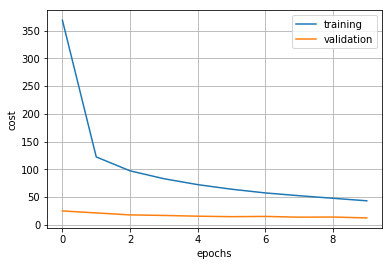

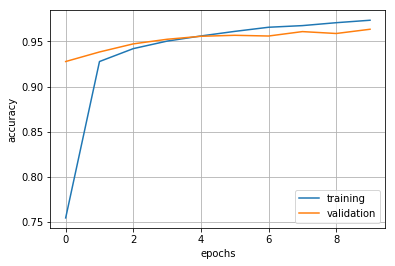

In [22]:
plt.figure(1)
plt.plot(train_costs, label='training')
plt.plot(eval_costs, label='validation')
plt.legend(loc='best')
plt.ylabel('cost')
plt.xlabel('epochs')
plt.grid(True)

# Plot accuracies here
# START TODO ################ 

plt.figure(2)
plt.plot(train_accuracies, label='training')
plt.plot(eval_accuracies, label='validation')
plt.legend(loc='best')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.grid(True)

#raise NotImplementedError
# END TODO ##################

plt.show()

** Your feedback on exercise 2.3: ** 

This part, in our point of view, is a really important one, since we can really notice how the different hyperparameters change the performance of our network. Every definition behind each hyperparameter can be tested and understood well when we apply and change them in our network. 
